<a href="#Import"> 1. Import Dependencies </a><br>
<a href="#Validate"> 2. Validate Data </a><br>
<a href="#Prune"> 3. Prune Data</a><br>
<a href="#ML"> 4. Machine Learning </a>

<hr>

## 1. Import Dependencies <a id='Import'></a>

In [25]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

from mongoHandler import mongoHandler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import shap


In [26]:
#mongoHandler = mongoHandler()
#mongoHandler.pullMongoDB("pastdata.csv")

## 2. Validate Data <a id=Validate></a>

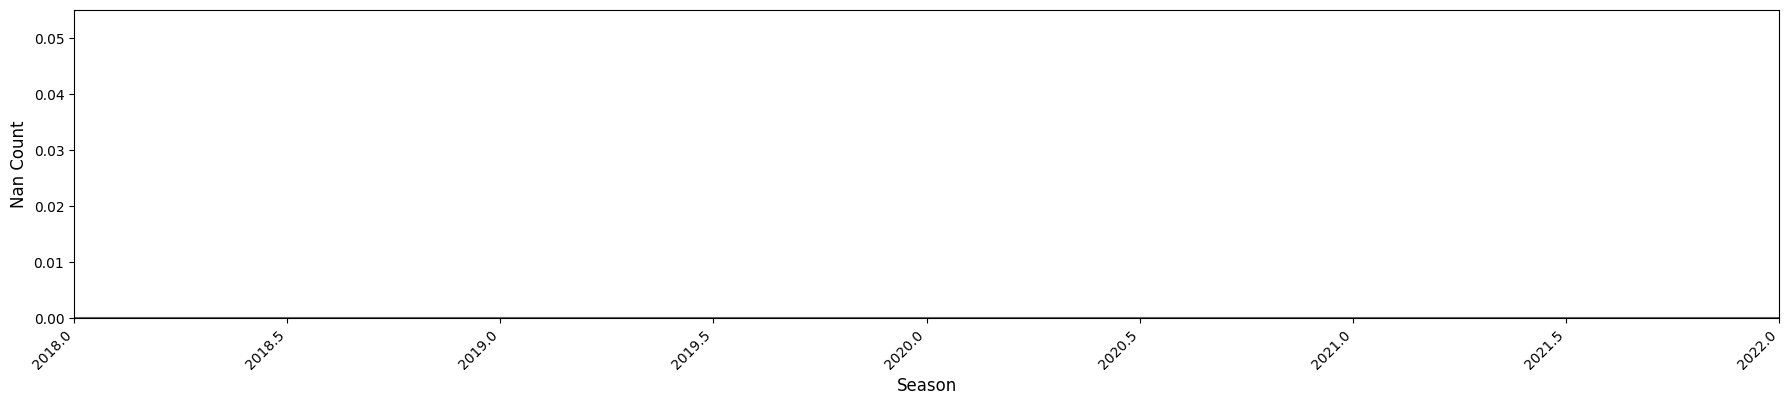

In [27]:
# This is optional as our data does not have any null values, but may be useful for other data sets
df = pd.read_csv("pastdata.csv")
prediction = pd.read_csv('2023data.csv')
df_detail_nan = []

for season in df['season'].unique():
    df_nan = df[df['season'] == season]
    series_nan = df_nan.isnull().sum()
    df_nan = series_nan.to_frame(name="Nan_Count")
    df_nan = df_nan.rename_axis('Col_Name').reset_index()
    df_nan['season'] = season
    df_detail_nan.append(df_nan)

df_detail_nan = pd.concat(df_detail_nan, ignore_index=True)

df_per_season_nan = df_detail_nan[['season','Nan_Count']].groupby("season").sum().reset_index()
df_per_season_nan = df_per_season_nan.sort_values(by=['season'], ascending=True)

fig = plt.figure(figsize = (22, 4))
sns.lineplot(data=df_per_season_nan, x="season", y="Nan_Count", sort=True)
plt.ylim(0)
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Season', fontsize=12)
plt.margins(x=0)
plt.show()

## 3. Prune Data <a id="Prune">

In [28]:
STATS_TO_DROP = [
    'players_used', 'games', 'games_starts', 'minutes', 'minutes_90s', 'goals', 'assists',
    'goals_assists', 'goals_pens', 'pens_made', 'pens_att', 'cards_yellow', 
    'cards_red','xg', 'npxg','xg_assist', 'npxg_xg_assist', 'gk_games', 
    'gk_games_starts', 'gk_minutes','gk_goals_against', 'gk_saves', 'gk_wins', 
    'gk_ties', 'gk_losses','gk_clean_sheets', 'gk_pens_att', 'gk_pens_allowed', 
    'gk_pens_saved', 'gk_pens_missed', 'gk_psxg_net', 'gk_passes_completed_launched',
    'gk_passes_launched', 'gk_crosses_stopped', 'gk_def_actions_outside_pen_area',
    'shots', 'shots_on_target', 'sca', 'gca'
]

In [29]:
df.drop(columns=STATS_TO_DROP, inplace=True)
prediction.drop(columns=STATS_TO_DROP, inplace=True)

## 4. Machine Learning <a id="ML"></a>

In [30]:
target = df['position']
features = df.drop(['position','team'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
#model = RandomForestClassifier()
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Test Prediction: {', '.join(map(str, y_pred))}")

Test Prediction: 16.44, 6.02, 5.76, 2.44, 8.06, 17.0, 16.04, 16.76, 8.32, 1.76, 9.34, 8.64, 17.0, 6.2, 14.24, 16.92, 17.0, 17.0, 9.6, 2.55, 16.2, 16.52, 9.84, 16.52, 17.0, 16.44, 2.42, 5.14, 4.63, 7.84, 16.52, 15.36


In [31]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f"MAE: {MAE.round(4)}")
print(f"MSE: {MSE.round(4)}")

MAE: 0.6025
MSE: 0.6681


In [32]:
prediction = prediction.drop(['team'],axis=1)
y_pred2 = model.predict(prediction)
print(f"2023 Prediction : {', '.join(map(str, y_pred2))}")

2023 Prediction : 16.92, 17.0, 13.8, 4.24, 4.51, 17.0, 5.45, 10.2, 16.68, 8.7, 9.48, 17.0, 2.6, 17.0, 17.0, 9.0, 16.84, 4.65, 16.68, 2.79, 4.78, 8.0, 9.08, 17.0, 10.28, 15.92, 4.13, 16.6, 16.12, 16.32, 9.6, 17.0


In [33]:
prediction

,avg_age,possession,progressive_carries,progressive_passes,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg_per90,...,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,topGoals,season
0,27.2,53.2,80,234,1.83,1.50,3.33,1.67,3.17,1.39,...,18,1,2,0,293,55,84,39.6,4,2023
1,29.5,56.5,111,286,0.67,0.50,1.17,0.67,1.17,1.59,...,20,1,1,0,309,75,81,48.1,1,2023
2,27.2,64.8,167,358,2.00,1.67,3.67,2.00,3.67,1.65,...,8,0,1,0,314,69,70,49.6,5,2023
3,27.4,56.1,249,541,2.10,1.90,4.00,2.00,3.90,1.94,...,26,0,1,0,574,105,113,48.2,4,2023
4,26.8,52.9,187,455,2.50,1.60,4.10,2.00,3.60,1.92,...,16,4,3,0,537,115,143,44.6,6,2023
5,26.8,44.2,98,300,0.50,0.17,0.67,0.50,0.67,1.53,...,4,1,2,0,291,42,43,49.4,2,2023
6,27.7,57.3,211,512,1.20,0.70,1.90,1.00,1.70,1.62,...,27,1,0,0,597,116,109,51.6,3,2023
7,27.1,45.6,109,239,1.00,0.87,1.87,0.87,1.75,1.00,...,14,2,3,0,389,114,96,54.3,2,2023
8,27.7,46.8,107,194,0.67,0.33,1.00,0.67,1.00,0.70,...,2,0,3,1,306,87,72,54.7,2,2023
9,26.8,47.9,159,300,1.37,1.25,2.62,1.37,2.62,1.31,...,8,0,2,0,427,68,86,44.2,4,2023


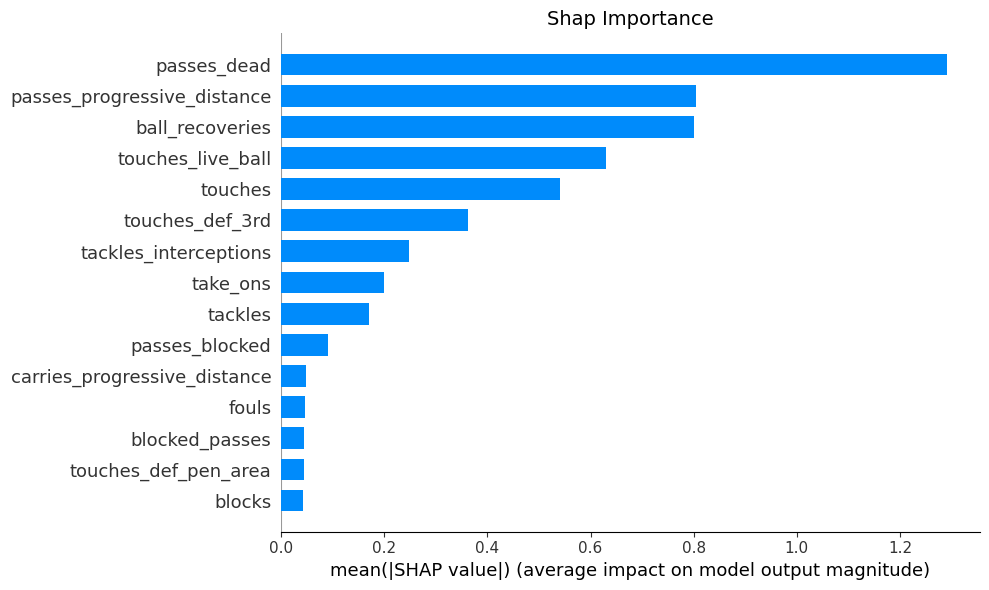

In [34]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features.columns.to_list(), 
                    show=False, max_display=15)

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("Shap Importance", fontsize=14, loc="center")   
plt.tight_layout()
plt.show()